![](../img/330-banner.png)

# Tutorial 5

UBC 2024-25

## Outline

During this tutorial, we will focus on calculating and understanding classification metrics, evaluating different classifiers, and addressing class imbalances.

All questions can be discussed with your classmates and the TAs - this is not a graded exercise!

In [42]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(".."), "code"))

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

from IPython.display import Image
pd.set_option("display.max_colwidth", 200)
DATA_DIR = "../data/"

For this exercise, we will use the same dataset on fraudulent and non-fraudulent transactions used in class (based on Kaggle's [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set).

In [43]:
# This dataset will be loaded using a URL instead of a CSV file
DATA_URL = "https://github.com/firasm/bits/raw/refs/heads/master/creditcard.csv"

cc_df = pd.read_csv(DATA_URL, encoding="latin-1")

Even our reduced version of this dataset is still large enough (almost 200k samples) that we can skip cross-validation, and create single training, validation and test sets:

In [44]:
# First split to create the test set
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)

X_train_big, y_train_big = train_df.drop(columns=["Class", "Time"]), train_df["Class"]

X_test, y_test = test_df.drop(columns=["Class", "Time"]), test_df["Class"] 

# Additional split to separate training and validation samples
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_big, y_train_big, test_size=0.3, random_state=123
)

We also know that this dataset is heavily unbalanced toward the negative class (non-fraud). Even a DummyClassifier would get more than 99% accuracy on this classification problem!

In [45]:
train_df["Class"].value_counts(normalize=True)

Class
0    0.9983
1    0.0017
Name: proportion, dtype: float64

### <font color='red'>Question 1</font>

Let's start by training a logistic regression model to separate the two classes included in this dataset. Then, observe the resulting confusion matrix, and compute **by hand** accuracy, recall and precision (you may use a calculator, but not the functions included in scikit-learn, like `classification_report`).

You may check your results using `classification_report` once you are done, but learning to calculate these metrics by looking at a confusion matrix is a good way to understand them.

Use the results to describe, for a non-expert audience, the behaviour of this classifier, answering questions such as:
- Is this classifier effective at finding fraudulent transactions?
    > The classifier is not effective because the recall is low. 
- When this classifier reports a fraudulent transaction, are we confident that it is right?
    > yes, 
- Is this classifier more likely to misclassify a fraud as a valid transaction, or vice-versa?
    > 

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.62      0.73       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.86     59810
weighted avg       1.00      1.00      1.00     59810



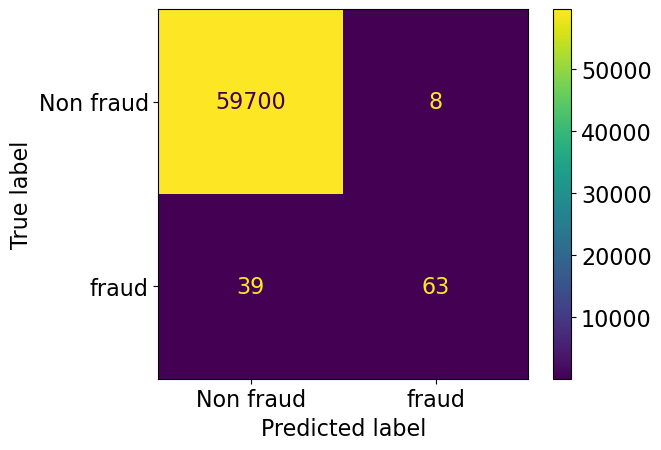

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay  

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)
cm = ConfusionMatrixDisplay.from_estimator(
    pipe, X_valid, y_valid, values_format="d", display_labels=["Non fraud", "fraud"]
)

y_pred_valid_normal = pipe.predict(X_valid)
report = classification_report(y_valid, y_pred_valid_normal, target_names=['non-fraud', 'fraud'])
print(report)

### <font color='red'>Question 2</font>

Next, we are going to try to address the problem of class imbalance as explained in this [video](https://www.youtube.com/watch?v=jHaKRCFb6Qw), by changing the weights of the samples.

Complete the code below to assign a weight of 50 to the positive class:

In [6]:
pipe_lr_weight = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=500, class_weight={0: 1, 1: 50}) # add parameters here
)

pipe_lr_weight.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight={0: 1, 1: 50}, max_iter=500))])

### <font color='red'>Question 3</font>

Now, repeat the analysis you did in Question 1 (you can use `classification_report` this time). 

Again, imagine to be addressing a general audience: 
- How would you describe the performance of this classifier, compared to the first one we tried?
    > 
- Is this classifier better or worse at finding fraudulent transactions?
- When this classifier reports a fraudulent transaction, are we more or less confident that it is right?

In [55]:
y_pred_lr_weight = pipe_lr_weight.predict(X_valid)
report_lr_weight = classification_report(y_valid, y_pred_lr_weight, target_names= ['non-fraud', 'fraud'])
print(report_lr_weight)

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.48      0.84      0.61       102

    accuracy                           1.00     59810
   macro avg       0.74      0.92      0.80     59810
weighted avg       1.00      1.00      1.00     59810



### <font color='red'>Question 4</font>

Before settling on a model, we will make one more attempt at changing the weights of the classes, this time using the `class_weight="balanced"` parameter.

The code is provided below. The scikit-learn documentation says that:

- "If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y))". 

According to this explanation, what is now the relative weight of the positive class? 
> n_samples/n_classes * frequency of y = w, inverse relationship between of sample size and frequency of the class

In [54]:
pipe_lr_balanced = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=500, class_weight="balanced")
)
pipe_lr_balanced.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

### <font color='red'>Question 5</font>

One more time, repeat your analysis, explaining your results to a general audience: 
- How would you describe the performance of this classifier, compared to the previous two?
- Is this classifier better or worse at finding fraudulent transactions?
- When this classifier reports a fraudulent transaction, are we more or less confident that it is right?

In [53]:
y_pred_balanced = pipe_lr_balanced.predict(X_valid)
report_balanced = classification_report(y_valid, y_pred_balanced, target_names= ['non-fraud', 'fraud'])
print(report_balanced)

              precision    recall  f1-score   support

   non-fraud       1.00      0.97      0.99     59708
       fraud       0.05      0.90      0.10       102

    accuracy                           0.97     59810
   macro avg       0.53      0.94      0.54     59810
weighted avg       1.00      0.97      0.98     59810



### <font color='red'>Question 6</font>

The lecture notes state:

- AUC can be interpreted as evaluating the **ranking** of positive examples.
- That is equivalent to the probability of a randomly picked positive point having a higher score according to the classifier than a randomly picked point from the negative class. 
- AUC of 1.0 means all positive points have a higher score than all negative points.

Based on these information, which one of the three classifiers that we trained do you expect to have the highest AUC score?

Compute the scores below to verify your answer!

In [ ]:
#Get prob for positive class
y_scores_baseline = pipe.predict_proba(X_valid)[:, 1]
y_scores_weighted = pipe_lr_weight.predict_proba(X_valid)[:, 1]
y_scores_balanced = pipe_lr_balanced.predict_proba(X_valid)[:, 1]

# Compute AUC scores
auc_baseline = roc_auc_score 

## ML fairness activity

AI/ML systems can give the illusion of objectivity as they are derived from seemingly unbiased data & algorithm. However, human are inherently biased and AI/ML systems, if not carefully evaluated, can even further amplify the existing inequities and systemic bias in our society.  

How do we make sure our AI/ML systems are *fair*? Which metrics can we use to quantify 'fairness' in AI/ML systems?

Let's examine this on [the adult census data set](https://www.kaggle.com/uciml/adult-census-income). 

In [8]:
census_df = pd.read_csv(DATA_DIR + "adult.csv")
census_df.shape

(32561, 15)

In [9]:
train_df, test_df = train_test_split(census_df, test_size=0.4, random_state=42)

In [10]:
train_df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
25823,36,Private,245521,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,35,Mexico,<=50K
10274,26,Private,134287,Assoc-voc,11,Never-married,Sales,Own-child,White,Female,0,0,35,United-States,<=50K
27652,25,Local-gov,109526,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,38,United-States,<=50K
13941,23,Private,131275,HS-grad,9,Never-married,Craft-repair,Own-child,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
31384,27,Private,193122,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,25,Private,410240,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
5390,51,Private,146767,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
860,55,Federal-gov,238192,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,1887,40,United-States,>50K
15795,41,Private,154076,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,50,United-States,>50K


### Preprocessing 

You may skip ahead or review as additional example of preprocessing.

In [11]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(19536, 15)

In [12]:
# Let's identify numeric and categorical features

numeric_features = [
    "age",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
]

categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "native.country",
]

ordinal_features = ["education"]
binary_features = [
    "sex"
]  # Not binary in general but in this particular dataset it seems to have only two possible values
drop_features = ["education.num", "fnlwgt"]
target = "income"

In [13]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [14]:
assert set(education_levels) == set(train_df["education"].unique())

In [15]:
X_train = train_df_nan.drop(columns=[target])
y_train = train_df_nan[target]

X_test = test_df_nan.drop(columns=[target])
y_test = test_df_nan[target]

In [16]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

numeric_transformer = make_pipeline(StandardScaler())

ordinal_transformer = OrdinalEncoder(categories=[education_levels], dtype=int)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

### Model training and evaluation

This dataset is a bit unbalanced (see count below), so we are going to train a logistic regression model with `class_weight="balanced"` to account for this.

In [17]:
y_train.value_counts()

income
<=50K    14841
>50K      4695
Name: count, dtype: int64

In [18]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(class_weight="balanced", max_iter=1000)
)

In [19]:
pipe_lr.fit(X_train, y_train);

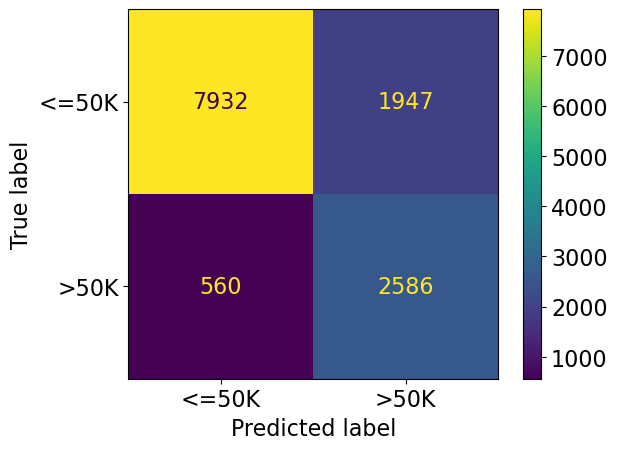

In [20]:
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test);

Let's examine confusion matrix separately for the two genders we have in the data. 

In [21]:
X_train_enc = preprocessor.fit_transform(X_train)
preprocessor.named_transformers_["pipeline-2"]["onehotencoder"].get_feature_names_out()

array(['x0_Male'], dtype=object)

In [22]:
X_female = X_test.query("sex=='Female'")  # X where sex is female
X_male = X_test.query("sex=='Male'")  # X where sex is male

y_female = y_test[X_female.index]  # y where sex is female
y_male = y_test[X_male.index]  # y where sex is male

**Get predictions for `X_female` and `y_male` with `pipe_lr`**

In [23]:
female_preds = pipe_lr.predict(X_female)
male_preds = pipe_lr.predict(X_male)

Examine the accuracy and confusion matrix for female and male classes:

In [24]:
print(classification_report(y_female, female_preds))

              precision    recall  f1-score   support

       <=50K       0.96      0.94      0.95      3851
        >50K       0.57      0.66      0.61       463

    accuracy                           0.91      4314
   macro avg       0.76      0.80      0.78      4314
weighted avg       0.92      0.91      0.91      4314



In [25]:
print(classification_report(y_male, male_preds))

              precision    recall  f1-score   support

       <=50K       0.91      0.72      0.80      6028
        >50K       0.57      0.85      0.68      2683

    accuracy                           0.76      8711
   macro avg       0.74      0.78      0.74      8711
weighted avg       0.81      0.76      0.77      8711



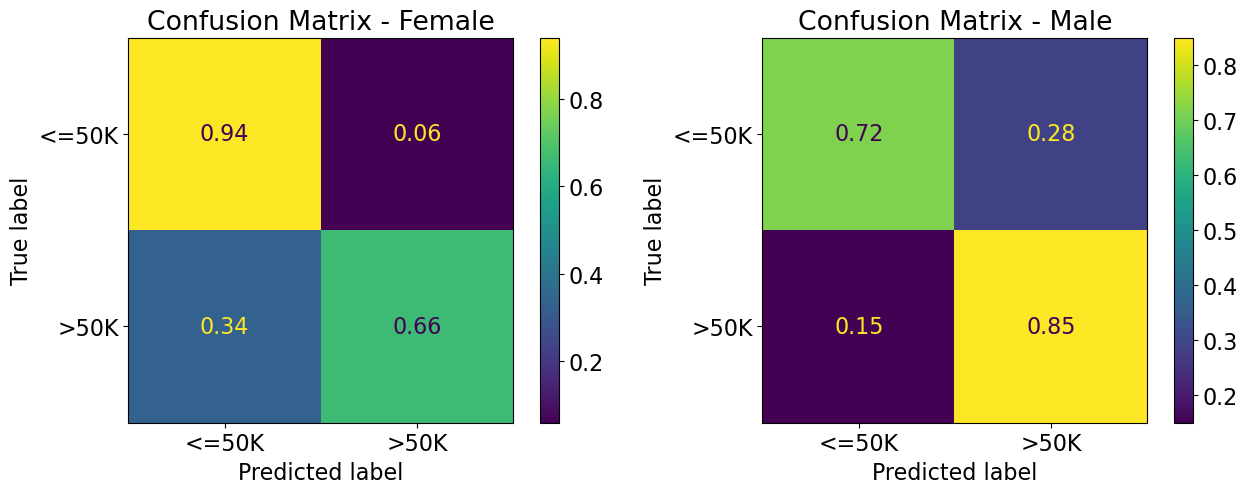

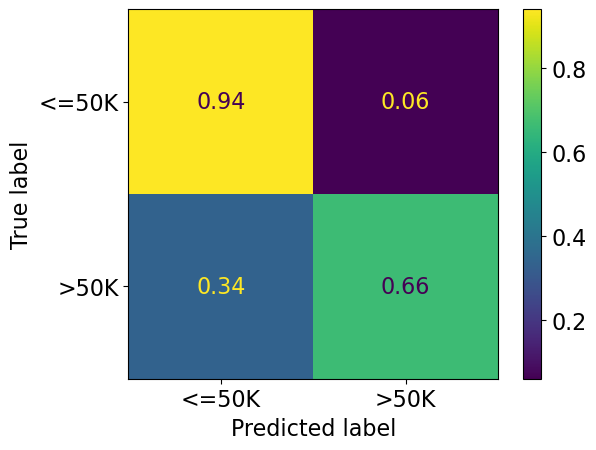

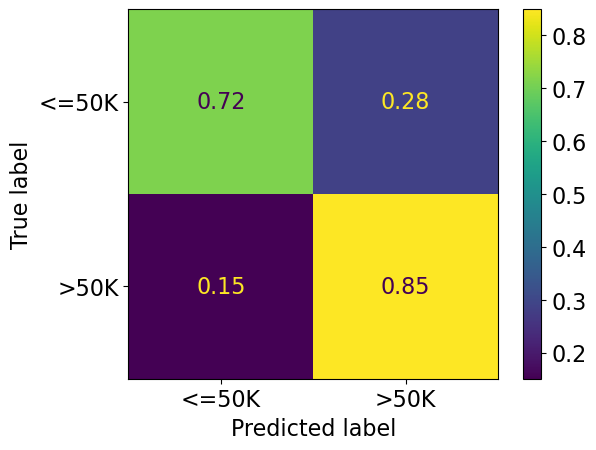

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the female confusion matrix
female_cm = ConfusionMatrixDisplay.from_estimator(pipe_lr, X_female, y_female, normalize="true");
axes[0].set_title('Confusion Matrix - Female');
female_cm.plot(ax=axes[0]);


# Plot the male confusion matrix
male_cm = ConfusionMatrixDisplay.from_estimator(pipe_lr, X_male, y_male, normalize="true");
axes[1].set_title('Confusion Matrix - Male');
male_cm.plot(ax=axes[1]);

### ❓❓ Questions for group discussion

Let's assume that a company is using this classifier for loan approval with a simple rule that if the income is >=50K, approve the loan else reject the loan. 

In your group, discuss the questions below. 

1. Which group has a higher accuracy?
2. Which group has a higher precision for class >50K? What about recall for class >50K?
3. Will both groups have more or less the same proportion of people with approved loans? 
4. If a male and a female have both a certain level of income, will they have the same chance of getting the loan?
5. Banks want to avoid approving unqualified applications (false positives) because default loan could have detrimental effects for them. Compare the false positive rates for the two groups.    
6. Overall, do you think this income classifier will fairly treat both groups? What will be the consequences of using this classifier in loan approval application? 
7. Do you think the effect will still exist if the sex feature is removed from the model (but you still have it available separately to do the two confusion matrices)? 
8. Are there any other groups in this dataset worth examining for biases? 
